In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from simplified_monorotor import Monorotor
import plotting
import testing
import trajectories

pylab.rcParams['figure.figsize'] = 10,10

# Feedforward control

The feedforward term captures the acceleration of the target path and adds to the $\bar{u}_1$ calculated by PD controller. 

$$
\ddot{z} = \bar{u}_1= k_p(z_t-z)+k_d(z_t-z)+\ddot{z}
$$ 

#### TODO - Implement PD controller WITH feed forward acceleration

Modify `thrust_control` to incorporate the feedforward term into the PD Controller math.

$$
\begin{align}
e &= z_{\text{target}} - z_{\text{actual}} \\
\dot{e} &= \dot{z}_{\text{target}} - \dot{z}_{\text{actual}} \\
\bar{u}_1 &= k_p e + k_d \dot{e} + \ddot{z}_{\text{ff}} \\
u_1 &= m(g - \bar{u}_1)
\end{align}
$$

In [7]:
class PDController:
    
    def __init__(self, k_p, k_d, m):
        self.k_p = k_p
        self.k_d = k_d
        self.vehicle_mass = m
        self.g = 9.81
    
    def thrust_control(self,
                z_target, 
                z_actual, 
                z_dot_target, 
                z_dot_actual,
                z_dot_dot_ff=0.0):
        #
        # TODO 
        #   modify the PD control code to incorporate
        #   the feedforward term.
        
        err = z_target - z_actual
        err_dot = z_dot_target - z_dot_actual
        u_bar = self.k_p * err + self.k_d * err_dot + z_dot_dot_ff
        # u_bar = self.k_p * err + self.k_d * err_dot 
        u = self.vehicle_mass * (self.g - u_bar) 
        
        return u
    
testing.pd_controller_test(PDController, feed_forward=True)

Tests pass


#### TODO 2 - Compare trajectories with and without a feedforward term

The code below generates plots of $z$ vs $t$ for two drones. One uses FF and the other doesn't.

Run the code and compare the two trajectories. What happens if you increase the oscillation frequency to 10? What happens if you decrease it to 2?

You should notice a **lag** in the system response: the trajectory without the feedforward term should lag behind the desired trajectory in time. This effect diminishes as the oscillation frequency decreases.

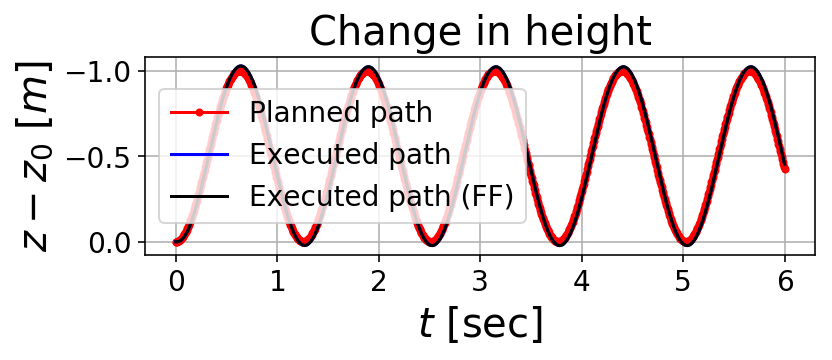

In [6]:
# This code simulates TWO drones. One uses the feed forward
# acceleration and the other doesn't. Note the difference in
# trajectories.

MASS_ERROR = 1.0
# K_P = 20.0
# K_D = 8.0
K_P = 120.0
K_D = 50.0


AMPLITUDE = 0.5
OSCILLATION_FREQUENCY = 5

PERIOD = 2 * np.pi / OSCILLATION_FREQUENCY

# preparation (TWO drones to compare)
drone = Monorotor()
ff_drone = Monorotor()
perceived_mass = drone.m * MASS_ERROR

# instantiate TWO controllers
controller    = PDController(K_P, K_D, perceived_mass)
ff_controller = PDController(K_P, K_D, perceived_mass)

# get trajectories
t, z_path, z_dot_path, z_dot_dot_path = trajectories.cosine(AMPLITUDE, 
                                                            PERIOD,
                                                           duration=6.0)
dt = t[1] - t[0]
# run simulation
history = []
ff_history = []
for z_target, z_dot_target, z_dot_dot_ff in zip(z_path, 
                                                z_dot_path, 
                                                z_dot_dot_path):
    z_actual = drone.z
    z_dot_actual = drone.z_dot
    
    ff_z_actual = ff_drone.z
    ff_z_dot_actual = ff_drone.z_dot
    
    u_ff = controller.thrust_control(z_target, ff_z_actual, 
                                  z_dot_target, ff_z_dot_actual,
                                  z_dot_dot_ff)
    u = controller.thrust_control(z_target, z_actual, 
                                  z_dot_target, z_dot_actual)
    
    drone.thrust = u
    ff_drone.thrust = u_ff
    
    drone.advance_state(dt)
    ff_drone.advance_state(dt)
    
    history.append(drone.X)
    ff_history.append(ff_drone.X)
    
# generate plots
z_actual = [h[0] for h in history]
z_ff_actual = [h[0] for h in ff_history]
plotting.compare_planned_to_actual(z_actual, z_path, t, 
                                   z_ff_actual)   

[Solution](/notebooks/PD%20with%20FF%20Solution.ipynb)